# Combining LabView BCS with Bluesky

## Overview

This notebook demonstrates how the LabView Beamline Control System API can be used to implement a "Single Motor Scan" as an `ophyd` device. Furthermore, this "Single Motor Scan" device can be initiated by the `bluesky` Run Engine as a `fly` plan with data avaliable in a bluesky run document.

### Brief Summary

The bluesky `fly` plan will cede control to an `ophyd` "[Fly-able Interface](http://nsls-ii.github.io/ophyd/architecture.html#fly-able-interface)" (e.g., [FlyerInterface](https://github.com/bluesky/ophyd/blob/dd4b3e389a0202ecacce39fc3965d703c616b0d4/ophyd/flyers.py#L17)) to collect data asynchronously, and then return data as "[event](https://blueskyproject.io/event-model/data-model.html#event-document)" documents.

The "Fly-able Interface" must:

1. `kickoff()` the scan
2. `complete()` data collection for the scan
3. `describe_collect()`: provide a descriptor for the data that is being collected
4. `collect()`: yield event document(s) that contain the data

More details about this concept of embedding external control system scans into bluesky can be found in [this example notebook](https://github.com/BCDA-APS/bluesky_training/blob/31-sscan-1D-as-flyer/sscan_1d_flyer.ipynb).

This example uses a _synchronous/blocking_ version of the BCS-API library (BCSz_sync.py), which is otherwise identical to the asynchronous version (BCSz.py). The blocking version was created because the bluesky Run Engine does not currently use `asyncio` `await` directive for the Fly-able interface methods.

## Credits

This example builds heavily upon two recently published works, as well as the many developers and contributors to the bluesky and BCS projects.

* [BCS-API](http://bcsapi.als.lbl.gov:3080): ZeroMQ library and python bindings (BCSz.py) developed by [Damon English](https://github.com/daenglis) for interfacing with the Advanced Light Source's BCS control system.
* [`sscan as 1D Flyer`](https://github.com/BCDA-APS/bluesky_training/blob/31-sscan-1D-as-flyer/sscan_1d_flyer.ipynb) example published by [Pete Jemian](https://github.com/prjemian) to demonstrate how the bluesky fly plan can be used to initiate scans and report data from external control systems (in that case, the EPICS sscan record).

# Prepare the notebook settings

In [1]:
from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not j|ust the last one
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import matplotlib
%matplotlib notebook

In [3]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [4]:
try:
    theNotebook
except NameError as e:
    theNotebook = "ALS-DXR-0066_XMCD_06b"
    theNotebook

'ALS-DXR-0066_XMCD_06b'

In [5]:
import logging
logger = logging.getLogger()
# logger.setLevel(logging.DEBUG)
logger.setLevel(logging.INFO)

# Setup bluesky

In [6]:
from bluesky import RunEngine

RE = RunEngine({})

In [7]:
from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()

# Send all metadata/data captured to the BestEffortCallback.
bec_token = RE.subscribe(bec)
bec.enable_table()  # Print hinted readings from the ‘primary’ stream in a LiveTable

# Make plots update live while scans run.
from bluesky.utils import install_kicker
install_kicker()

In [8]:
from dotenv import load_dotenv

load_dotenv()  # import environment variables from .env

True

In [9]:
from databroker import Broker
db = Broker.named('TEST')

# Insert all metadata/data captured into db.
RE.subscribe(db.insert)

1

In [10]:
from bluesky.utils import ProgressBarManager
RE.waiting_hook = ProgressBarManager()

In [11]:
RE.md['notebook'] = theNotebook
RE.md

{'versions': {'ophyd': '1.6.3', 'bluesky': '1.8.1'},
 'notebook': 'ALS-DXR-0066_XMCD_06b'}

# Setup motors

## Connected to LabView BCS using EPICS CA protocol

LabView EPICS module needs to be running on `BL402BCS` and no one else must be using the beamline.

Contact Padraic pshafer@lbl.gov before running any scripts below from a computer that can access `BCS402` PVs

In [12]:
import sys
from os.path import dirname, abspath, join
bl402_epics_path = join(dirname(abspath('')), "bl402-epics") 
sys.path.append(bl402_epics_path)
print(bl402_epics_path)

from blue_bcs import motors, counters

C:\experiments\beamline_commissioning\bl402-epics


Unable to import 'fcntl'. Will be unable to lock files


## Get sample position

In [13]:
from blue_bcs.motors import vmm_xyz

In [14]:
vmm_xyz.wait_for_connection(timeout=15.0)
vmm_xyz.read()

OrderedDict([('vmm_stage_x', {'value': 0.501, 'timestamp': 1635887864.408586}),
             ('vmm_stage_x_user_setpoint',
              {'value': 0.501, 'timestamp': 1635887864.408586}),
             ('vmm_stage_y', {'value': 7.0, 'timestamp': 631152000.0}),
             ('vmm_stage_y_user_setpoint',
              {'value': 7.0, 'timestamp': 631152000.0}),
             ('vmm_stage_z',
              {'value': -0.002, 'timestamp': 1635887706.683895}),
             ('vmm_stage_z_user_setpoint',
              {'value': 0.0, 'timestamp': 1635887706.683895}),
             ('vmm_stage_rotation',
              {'value': -30.003, 'timestamp': 1635887712.070543}),
             ('vmm_stage_rotation_user_setpoint',
              {'value': -30.003, 'timestamp': 1635887712.070543})])

## Define sample positions

In [15]:
samples = {
    "HEA_39": {
        "z": 38.0
    },
    "HEA_40": {
        "z": 57.5
    },
    "HEO_1": {
        "z": 73.0
    },
    "HEO_2": {
        "z": 78.5
    },
}

# Connect to BCS server

In [16]:
import os
import collections

# import bcs_api
from bcs_api import BCSz, BcsSigFlyScanFlyer, BcsTrajectoryScan, BcsTrajScanFlyer

In [17]:
bl402bcs = BCSz.BCSServer()

bl402bcs.connect(addr=str(os.environ["BCS_SERVER"]), port=int(os.environ["BCS_PORT"]))

Server Public Key b'zTO/M.r1z>7T/dZLw#beAltt3sdg?7R=DvVI9W[u'


### Start the Beamline Scan GUI before running the scan

In [18]:
from bluesky.plans import fly

from matplotlib import pyplot as plt

In [19]:
fly_FlyXmcd = BcsTrajScanFlyer("BCS402:", name="ssflyFlyXmcd")

In [20]:
fly_FlyXmcd.scan_setup(
        bcs_server=bl402bcs, 
        input_file_path=os.path.join(
            str(os.environ["BCS_REMOTE_SCAN_PATH"]),
            "Padraic\\2021-10-27\\Co_XMCD_x4.scn",
            ), 
        subpath_replace_dict=collections.OrderedDict([
            (str(os.environ["BCS_REMOTE_SCAN_PATH"]), str(os.environ["BCS_LOCAL_SCAN_PATH"])),
            ])
    )

In [21]:
fly_FlyXmcd.get()

BcsTrajScanFlyerTuple(input_file_path='C:\\\\experiments\\\\Padraic\\2021-10-27\\Co_XMCD_x4.scn', delay_sec=0.0, count_sec=1.0, num_scans=1, skip_unchanged_motors=True, move_sequentially=False, shift_flying_data=False, final_move='Stay', final_trajectory_name='', memo='', filename_pattern='*.txt', ready=True, busy=False, done=True, execute_scan=True, data_paths='', normal_motors=['Hx', 'EPU Polarization'], flying_motor='Beamline Energy', stream_event_sizes=[1201, 1201, 0, 1201, 1201, 0, 1201, 1201, 0, 1201, 1201, 0], yield_array_events=True)

In [22]:
data_files = list()
normalization_signals = ["I0 BL", "I0 ES", "Clock"]
intensity_signals = ["EY", "LY"]
primary_motor = "Captured Mono Energy"
    
RE(fly(
    [fly_FlyXmcd], 
    md=dict(
        purpose="testing XMCD",
        sample_name="NONE",
        scan_type="flying",
        project="DD-00598-001: Magnetic Interactions in High Entropy Magnetic Systems",
        beamline="4.0.2",
        endstation="VMM",
        tracking="ALS-DXR-0066",
        normalization_signals=normalization_signals,
        intensity_signals=intensity_signals,
        hints={
            "dimensions": [([primary_motor], "primary")],
            "fields": intensity_signals,
        },
    ),
))

INFO:bluesky:Executing plan <generator object fly at 0x0000016FE2CA1040>
INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x0000016FC9E90310> from 'idle' -> 'running'




Transient Scan ID: 1     Time: 2021-10-31 17:51:27
Persistent Unique Scan ID: 'b3caadd6-6e99-4fb1-83ac-5a1839210df4'


INFO:root:complete() starting


Adding new data file
ssflyFlyXmcd_done [In progress. No progress bar available.]                                                            
Adding new data file
Adding new data file
Adding new data file
Scan is finshed!


INFO:root:complete() ending


ssflyFlyXmcd_done [In progress. No progress bar available.]                                                            
                                                                                                                       
Creating new stream primary
...New event_size = 1201
...Previous stream_event_size = None
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | Captured Mono Energy |
+-----------+------------+----------------------+


C:\experiments\beamline_commissioning\BCS-API\bcs_events.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df[output_col] = datetimes
C:\Users\admin\miniconda3\envs\bluesky\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\admin\miniconda3\envs\bluesky\lib\site-packages\event_model\__init__.py:208: UserWarning: The document type 'bulk_events' has been deprecated in favor of 'event_page', whose structure is a transpose of 'bulk_events'.
  warnings.warn(


+-----------+------------+----------------------+
generator fly ['b3caadd6'] (scan num: 1)





INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x0000016FC9E90310> from 'running' -> 'idle'
INFO:bluesky:Cleaned up from plan <generator object fly at 0x0000016FE2CA1040>


('b3caadd6-6e99-4fb1-83ac-5a1839210df4',)

MoveStatus(done=True, pos=vmm_stage_z, elapsed=34.5, success=True, settle_time=0.0)

INFO:bluesky:Executing plan <generator object fly at 0x0000016FE2E6BAC0>
INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x0000016FC9E90310> from 'idle' -> 'running'




Transient Scan ID: 2     Time: 2021-10-31 18:13:52
Persistent Unique Scan ID: '07380931-2eff-451a-949b-3d97626c106a'


INFO:root:complete() starting


Adding new data file
ssflyFlyXmcd_done [In progress. No progress bar available.]                                                            
Adding new data file
Adding new data file
Adding new data file
Scan is finshed!


INFO:root:complete() ending


ssflyFlyXmcd_done [In progress. No progress bar available.]                                                            
                                                                                                                       
Creating new stream primary
...New event_size = 1201
...Previous stream_event_size = None
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | Captured Mono Energy |
+-----------+------------+----------------------+
+-----------+------------+----------------------+
generator fly ['07380931'] (scan num: 2)





INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x0000016FC9E90310> from 'running' -> 'idle'
INFO:bluesky:Cleaned up from plan <generator object fly at 0x0000016FE2E6BAC0>


('07380931-2eff-451a-949b-3d97626c106a',)

False

True

data_file=['C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000206 01.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000206 02.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000206 03.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000206 04.txt']


<IPython.core.display.Javascript object>


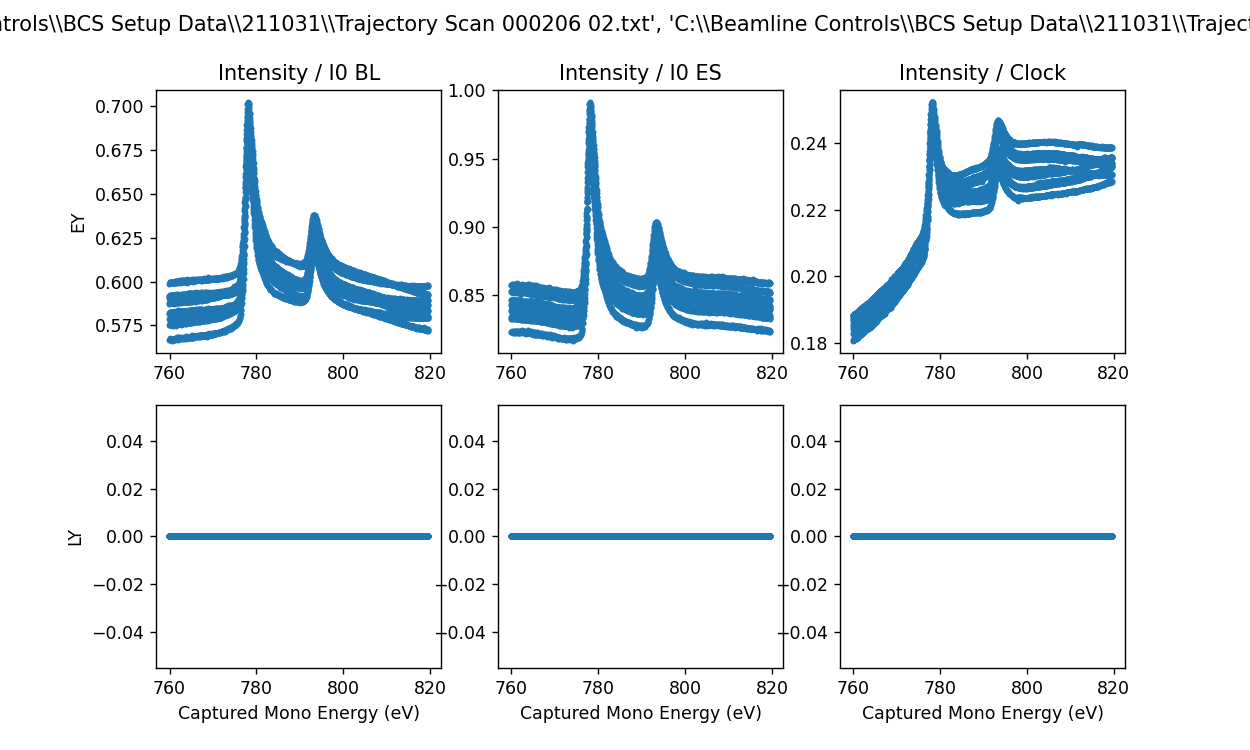

Text(0.5, 0, 'Captured Mono Energy (eV)')

Text(0.5, 0, 'Captured Mono Energy (eV)')

Text(0.5, 0, 'Captured Mono Energy (eV)')

Text(0, 0.5, 'EY')

Text(0, 0.5, 'LY')

Text(0.5, 1.0, 'Intensity / I0 BL')

Text(0.5, 1.0, 'Intensity / I0 ES')

Text(0.5, 1.0, 'Intensity / Clock')

Text(0.5, 0.98, "Scan# ['C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000206 01.txt', 'C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000206 02.txt', 'C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000206 03.txt', 'C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000206 04.txt']")

MoveStatus(done=True, pos=vmm_stage_z, elapsed=17.7, success=True, settle_time=0.0)

INFO:bluesky:Executing plan <generator object fly at 0x0000016FE2E57F20>
INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x0000016FC9E90310> from 'idle' -> 'running'




Transient Scan ID: 3     Time: 2021-10-31 18:32:05
Persistent Unique Scan ID: '228a4b9a-edb5-4d0e-89c4-e90526332f18'


INFO:root:complete() starting


Adding new data file
ssflyFlyXmcd_done [In progress. No progress bar available.]                                                            
Adding new data file
Adding new data file
Adding new data file
Scan is finshed!


INFO:root:complete() ending


ssflyFlyXmcd_done [In progress. No progress bar available.]                                                            
                                                                                                                       
Creating new stream primary
...New event_size = 1201
...Previous stream_event_size = None
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | Captured Mono Energy |
+-----------+------------+----------------------+
+-----------+------------+----------------------+
generator fly ['228a4b9a'] (scan num: 3)





INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x0000016FC9E90310> from 'running' -> 'idle'
INFO:bluesky:Cleaned up from plan <generator object fly at 0x0000016FE2E57F20>


('228a4b9a-edb5-4d0e-89c4-e90526332f18',)

False

True

data_file=['C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000207 01.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000207 02.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000207 03.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000207 04.txt']


<IPython.core.display.Javascript object>


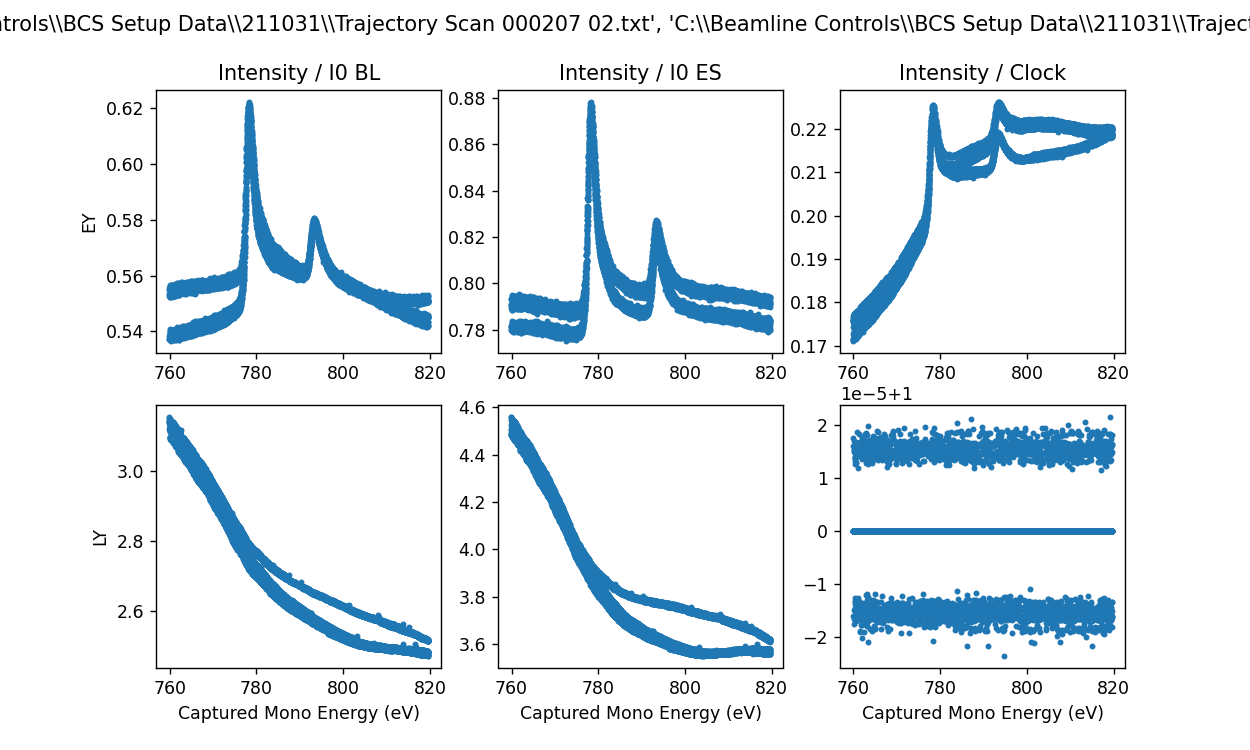

Text(0.5, 0, 'Captured Mono Energy (eV)')

Text(0.5, 0, 'Captured Mono Energy (eV)')

Text(0.5, 0, 'Captured Mono Energy (eV)')

Text(0, 0.5, 'EY')

Text(0, 0.5, 'LY')

Text(0.5, 1.0, 'Intensity / I0 BL')

Text(0.5, 1.0, 'Intensity / I0 ES')

Text(0.5, 1.0, 'Intensity / Clock')

Text(0.5, 0.98, "Scan# ['C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000207 01.txt', 'C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000207 02.txt', 'C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000207 03.txt', 'C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000207 04.txt']")

MoveStatus(done=True, pos=vmm_stage_z, elapsed=14.5, success=True, settle_time=0.0)

INFO:bluesky:Executing plan <generator object fly at 0x0000016FE607A740>
INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x0000016FC9E90310> from 'idle' -> 'running'




Transient Scan ID: 4     Time: 2021-10-31 18:50:15
Persistent Unique Scan ID: '79e76c58-a100-4f8f-9fc5-981a9cd8600d'


INFO:root:complete() starting


Adding new data file
ssflyFlyXmcd_done [In progress. No progress bar available.]                                                            
Adding new data file
Adding new data file
Adding new data file
Scan is finshed!


INFO:root:complete() ending


ssflyFlyXmcd_done [In progress. No progress bar available.]                                                            
                                                                                                                       
Creating new stream primary
...New event_size = 1201
...Previous stream_event_size = None
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | Captured Mono Energy |
+-----------+------------+----------------------+
+-----------+------------+----------------------+
generator fly ['79e76c58'] (scan num: 4)





INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x0000016FC9E90310> from 'running' -> 'idle'
INFO:bluesky:Cleaned up from plan <generator object fly at 0x0000016FE607A740>


('79e76c58-a100-4f8f-9fc5-981a9cd8600d',)

False

True

data_file=['C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000208 01.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000208 02.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000208 03.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000208 04.txt']


<IPython.core.display.Javascript object>


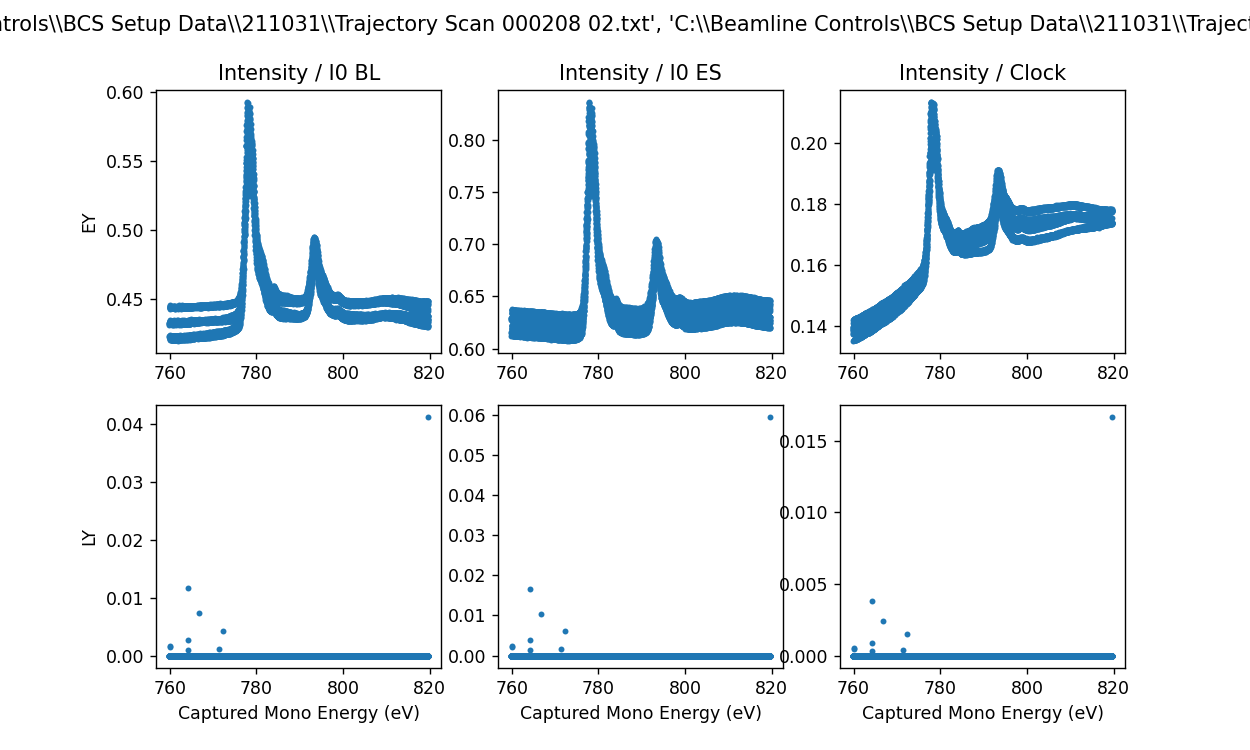

Text(0.5, 0, 'Captured Mono Energy (eV)')

Text(0.5, 0, 'Captured Mono Energy (eV)')

Text(0.5, 0, 'Captured Mono Energy (eV)')

Text(0, 0.5, 'EY')

Text(0, 0.5, 'LY')

Text(0.5, 1.0, 'Intensity / I0 BL')

Text(0.5, 1.0, 'Intensity / I0 ES')

Text(0.5, 1.0, 'Intensity / Clock')

Text(0.5, 0.98, "Scan# ['C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000208 01.txt', 'C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000208 02.txt', 'C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000208 03.txt', 'C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000208 04.txt']")

MoveStatus(done=True, pos=vmm_stage_z, elapsed=6.4, success=True, settle_time=0.0)

INFO:bluesky:Executing plan <generator object fly at 0x0000016FE607A430>
INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x0000016FC9E90310> from 'idle' -> 'running'




Transient Scan ID: 5     Time: 2021-10-31 19:08:16
Persistent Unique Scan ID: '914a2960-8351-42ed-b641-7df0267ccb6c'


INFO:root:complete() starting


Adding new data file
ssflyFlyXmcd_done [In progress. No progress bar available.]                                                            
Adding new data file
Adding new data file
Adding new data file
Scan is finshed!


INFO:root:complete() ending


ssflyFlyXmcd_done [In progress. No progress bar available.]                                                            
                                                                                                                       
Creating new stream primary
...New event_size = 1201
...Previous stream_event_size = None
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | Captured Mono Energy |
+-----------+------------+----------------------+
+-----------+------------+----------------------+
generator fly ['914a2960'] (scan num: 5)





INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x0000016FC9E90310> from 'running' -> 'idle'
INFO:bluesky:Cleaned up from plan <generator object fly at 0x0000016FE607A430>


('914a2960-8351-42ed-b641-7df0267ccb6c',)

False

True

data_file=['C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000209 01.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000209 02.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000209 03.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000209 04.txt']


<IPython.core.display.Javascript object>


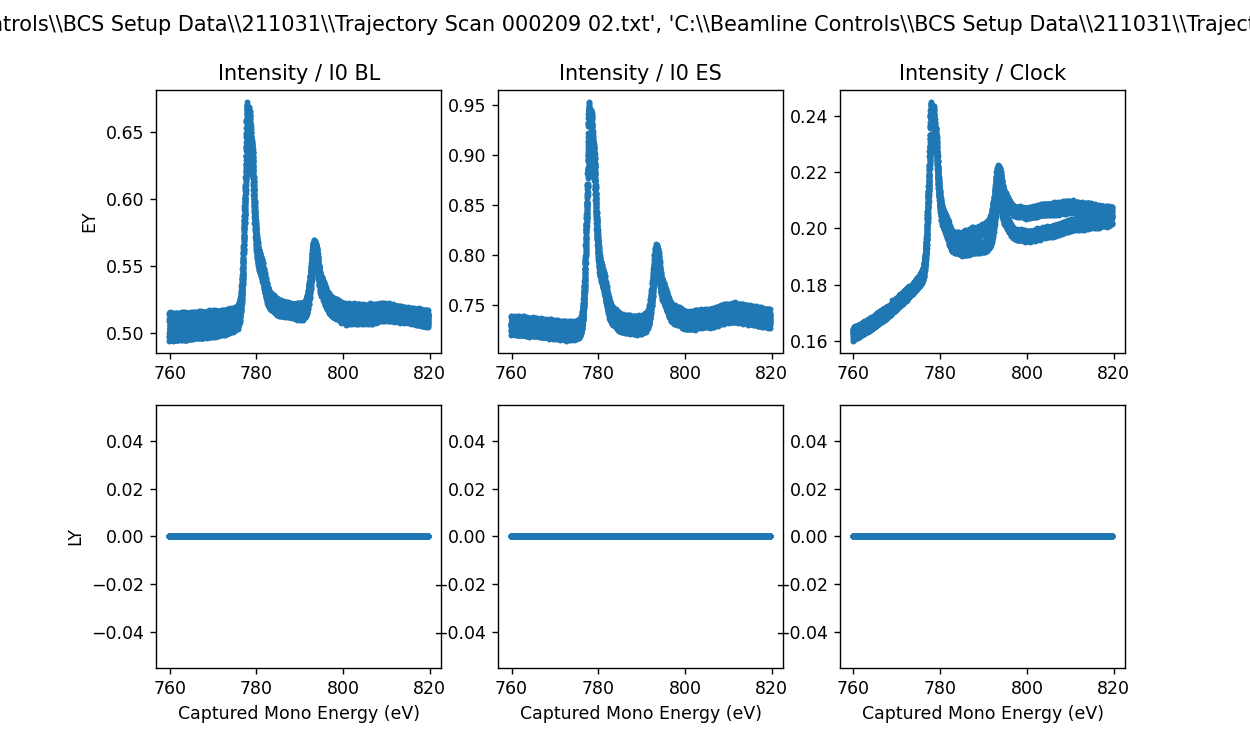

Text(0.5, 0, 'Captured Mono Energy (eV)')

Text(0.5, 0, 'Captured Mono Energy (eV)')

Text(0.5, 0, 'Captured Mono Energy (eV)')

Text(0, 0.5, 'EY')

Text(0, 0.5, 'LY')

Text(0.5, 1.0, 'Intensity / I0 BL')

Text(0.5, 1.0, 'Intensity / I0 ES')

Text(0.5, 1.0, 'Intensity / Clock')

Text(0.5, 0.98, "Scan# ['C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000209 01.txt', 'C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000209 02.txt', 'C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000209 03.txt', 'C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211031\\\\Trajectory Scan 000209 04.txt']")

data_files=[['C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000206 01.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000206 02.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000206 03.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000206 04.txt'], ['C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000207 01.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000207 02.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000207 03.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000207 04.txt'], ['C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000208 01.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000208 02.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000208 03.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211031\\Trajectory Scan 000208 04.txt'], ['C:\\Beamline Control

In [23]:
data_files = list()
normalization_signals = ["I0 BL", "I0 ES", "Clock"]
intensity_signals = ["EY", "LY"]
primary_motor = "Captured Mono Energy"

for sample_name in ["HEA_39", "HEA_40", "HEO_1", "HEO_2"]:

    for coord, value in samples[sample_name].items():
        # print(vmm_xyz.__dict__["_signals"][coord])
        vmm_xyz.__dict__["_signals"][coord].move(value)
    
    RE(fly(
        [fly_FlyXmcd], 
        md=dict(
            purpose="example XMCD vs. sample",
            sample_name=sample_name,
            scan_type="flying",
            project="DD-00598-001: Magnetic Interactions in High Entropy Magnetic Systems",
            beamline="4.0.2",
            endstation="VMM",
            tracking="ALS-DXR-0066",
            normalization_signals=normalization_signals,
            intensity_signals=intensity_signals,
            hints={
                "dimensions": [([primary_motor], "primary")],
                "fields": intensity_signals,
            },
        ),
    ))
    
    fly_FlyXmcd.busy.get()
    fly_FlyXmcd.done.get()
    data_file = fly_FlyXmcd.data_paths.get()
    print(f"{data_file=}")
    
    data_files.append(data_file)
    
    run = db.v2[-1]
    data = run.primary.read()
    
    fig, axes = plt.subplots(nrows=len(intensity_signals), ncols=len(normalization_signals), figsize=(10,6))
    axes_iter = iter(axes.flatten())
    for intensity_signal in intensity_signals:
        for normalization_signal in normalization_signals:

            ax=next(axes_iter)
            ax.scatter(
                x=data[primary_motor], 
                y=data[intensity_signal] / data[normalization_signal], 
                linestyles='-', 
                linewidths=2,
                s=2,
                )
    for ax in axes[-1]:
        ax.set_xlabel(f"{primary_motor} (eV)") # Assume energy units
    for (ax, signal) in zip(axes[:, 0], intensity_signals):
        ax.set_ylabel(f"{signal}")
    for (ax, norm_signal) in zip(axes[0], normalization_signals):
        ax.set_title(f"Intensity / {norm_signal}")
    fig.suptitle(f'Scan# {data_file}')
    plt.show()

print(f"{data_files=}")

# Which control layer is ophyd using

In [18]:
from ophyd import cl

cl

namespace(setup=<function ophyd._pyepics_shim.setup(logger)>,
          caput=<function epics.caput(pvname, value, wait=False, timeout=60.0, connection_timeout=5.0)>,
          caget=<function epics.caget(pvname, as_string=False, count=None, as_numpy=True, use_monitor=True, timeout=5.0, connection_timeout=5.0)>,
          get_pv=<function epics.pv.get_pv(pvname, form='time', connect=False, context=None, timeout=5.0, connection_callback=None, access_callback=None, callback=None, verbose=False, count=None, auto_monitor=None)>,
          thread_class=epics.ca.CAThread,
          name='pyepics',
          release_pvs=<function ophyd._pyepics_shim.release_pvs(*pvs)>,
          get_dispatcher=<function ophyd._pyepics_shim.get_dispatcher()>)

# Magnetic Hysteresis Loops (Flying Scans)

In [19]:
from dotenv import load_dotenv

load_dotenv()  # import environment variables from .env

True

## Get Beamline Energy

In [20]:
from blue_bcs.motors import epu, mono

In [21]:
epu.wait_for_connection(timeout=15.0)
epu.read()

OrderedDict([('epu_energy',
              {'value': 1984.0320000000002, 'timestamp': 1635890663.008787}),
             ('epu_energy_user_setpoint',
              {'value': 1984.0320000000002, 'timestamp': 1635890663.008787}),
             ('epu_polarization',
              {'value': 0.0, 'timestamp': 1635890662.589763}),
             ('epu_polarization_user_setpoint',
              {'value': 0.0, 'timestamp': 1635890662.589763}),
             ('epu_gap', {'value': 101.0, 'timestamp': 1635900320.168123}),
             ('epu_gap_user_setpoint',
              {'value': 101.001, 'timestamp': 1635900320.168123}),
             ('epu_z', {'value': 0.016, 'timestamp': 1635890871.281012}),
             ('epu_z_user_setpoint',
              {'value': 0.016, 'timestamp': 1635890871.281012}),
             ('epu_harmonic', {'value': 3.0, 'timestamp': 631152000.0}),
             ('epu_harmonic_user_setpoint',
              {'value': 3.0, 'timestamp': 631152000.0}),
             ('epu_soft_limit', {'

In [22]:
mono.wait_for_connection(timeout=15.0)
mono.read()

OrderedDict([('mono_energy',
              {'value': 699.873, 'timestamp': 1635900854.749098}),
             ('mono_energy_user_setpoint',
              {'value': 700.0260000000001, 'timestamp': 1635900844.715482}),
             ('mono_grating',
              {'value': 29206.27, 'timestamp': 1635900852.789236}),
             ('mono_grating_user_setpoint',
              {'value': 29204.36, 'timestamp': 1635900842.755509}),
             ('mono_premirror',
              {'value': 26751.07, 'timestamp': 1635900854.809041}),
             ('mono_premirror_user_setpoint',
              {'value': 26750.38, 'timestamp': 1635900844.775524}),
             ('mono_jack', {'value': -931.78, 'timestamp': 1635900705.85704}),
             ('mono_jack_user_setpoint',
              {'value': -931.86, 'timestamp': 1635900705.85704}),
             ('mono_transverse',
              {'value': 40500.782, 'timestamp': 631152000.0}),
             ('mono_transverse_user_setpoint',
              {'value': 40500.7

## Define energies for loops

In [23]:
sample_energies = {
    "HEA_39": {
        "Fe": 707.25,
        "Co": 777.95,
        "Ni": 852.25,
        },
    "HEA_40": {
        "Cr": 573.7,
        "Fe": 707.25,
        "Co": 778.10,
        "Ni": 852.20,
        },
    "HEO_1": {
        "Cr": 577.0,
        "Mn": 641.00,
        "Fe": 708.40,
        "Co": 777.95,
        "Ni": 852.80,
        },
    "HEO_2": {
        "Cr": 577.0,
        "Mn": 641.00,
        "Fe": 708.40,
        "Co": 777.95,
        "Ni": 852.80,
        },
}

# Connect to VMM server

In [24]:
import os
import collections

# import bcs_api
from bcs_api import BCSz, BcsSigFlyScanFlyer, BcsTrajectoryScan, BcsTrajScanFlyer

In [25]:
bl402vmm = BCSz.BCSServer()

bl402vmm.connect(addr=str(os.environ["VMM_SERVER"]), port=int(os.environ["VMM_PORT"]))

Server Public Key b'3aN*]cwY2<[:lwr=h<pGmTR>kcBQ@zW0=1E!z-k:'


### Start the Beamline Scan GUI before running the scan

In [26]:
from bluesky.plans import fly

from matplotlib import pyplot as plt

### Single Motor Flying Scan

In [27]:
fly_FlyMagField = BcsSigFlyScanFlyer("BCS402_VMM:", name="ssflyFlyMagField")

In [28]:
fly_FlyMagField.scan_setup(
        bcs_server=bl402vmm, 
        motor="Hx", start=0.25, stop=-0.25, step=-0.005, velocity=0.025,
        num_scans=2, bidirect=True,
        shift_flying_data=True,
    )

In [29]:
fly_FlyMagField.get()

BcsSigFlyScanFlyerTuple(motor_name='Hx', first_value=0.25, last_value=-0.25, step_value=-0.005, velocity=0.025, num_scans=2, bidirectional=True, shift_flying_data=True, final_move='Stay', memo='', filename_pattern='*.txt', ready=True, busy=False, done=True, execute_scan=True, data_path='', yield_array_events=True)

In [30]:
data_files = list()
normalization_signals = ["I0 BL", "I0 ES", "Clock"]
intensity_signals = ["EY", "LY"]
primary_motor = "Hx"
sample_name = "None"
element = "None"

RE(fly(
    [fly_FlyMagField], 
    md=dict(
        purpose="demo bluesky fly plan with BCS Single Motor Flying Scan",
        sample_name=sample_name,
        element=element, 
        scan_type="flying",
        project="DD-00598-001: Magnetic Interactions in High Entropy Magnetic Systems",
        beamline="4.0.2",
        endstation="VMM",
        tracking="ALS-DXR-0066",
        normalization_signals=normalization_signals,
        intensity_signals=intensity_signals,
        hints={
            "dimensions": [([primary_motor], "primary")],
            "fields": intensity_signals,
        },
        ),
    ))

fly_FlyMagField.busy.get()
fly_FlyMagField.done.get()
data_file = fly_FlyMagField.data_path.get()
print(f"{data_file=}")

data_files.append(data_file)

INFO:bluesky:Executing plan <generator object fly at 0x000001B121742660>
INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x000001B1084B1EB0> from 'idle' -> 'running'




Transient Scan ID: 1     Time: 2021-11-02 17:54:23
Persistent Unique Scan ID: 'e85fe0b0-2742-4109-bc01-6f79c18b00f1'


INFO:root:complete() starting


ssflyFlyMagField_done [In progress. No progress bar available.]                                                        
Scan is finshed!


INFO:root:complete() ending


ssflyFlyMagField_done [In progress. No progress bar available.]                                                        
                                                                                                                       
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |         Hx |
+-----------+------------+------------+


C:\Users\admin\miniconda3\envs\bluesky\lib\site-packages\event_model\__init__.py:208: UserWarning: The document type 'bulk_events' has been deprecated in favor of 'event_page', whose structure is a transpose of 'bulk_events'.
  warnings.warn(


+-----------+------------+------------+
generator fly ['e85fe0b0'] (scan num: 1)





INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x000001B1084B1EB0> from 'running' -> 'idle'
INFO:bluesky:Cleaned up from plan <generator object fly at 0x000001B121742660>


('e85fe0b0-2742-4109-bc01-6f79c18b00f1',)

False

True

data_file='C:\\Beamline Controls\\BCS Setup Data\\211102\\SigScan 400061.txt'


INFO:bluesky:Executing plan <generator object fly at 0x000001B1215C7A50>
INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x000001B1084B1EB0> from 'idle' -> 'running'




Transient Scan ID: 2     Time: 2021-11-02 17:56:16
Persistent Unique Scan ID: 'f3f078fb-7e53-454f-8505-6088146bf310'


INFO:root:complete() starting


ssflyFlyMagField_done [In progress. No progress bar available.]                                                        
Scan is finshed!


INFO:root:complete() ending


ssflyFlyMagField_done [In progress. No progress bar available.]                                                        
                                                                                                                       
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |         Hx |
+-----------+------------+------------+
+-----------+------------+------------+
generator fly ['f3f078fb'] (scan num: 2)





INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x000001B1084B1EB0> from 'running' -> 'idle'
INFO:bluesky:Cleaned up from plan <generator object fly at 0x000001B1215C7A50>


('f3f078fb-7e53-454f-8505-6088146bf310',)

False

True

data_file='C:\\Beamline Controls\\BCS Setup Data\\211102\\SigScan 400062.txt'


<IPython.core.display.Javascript object>


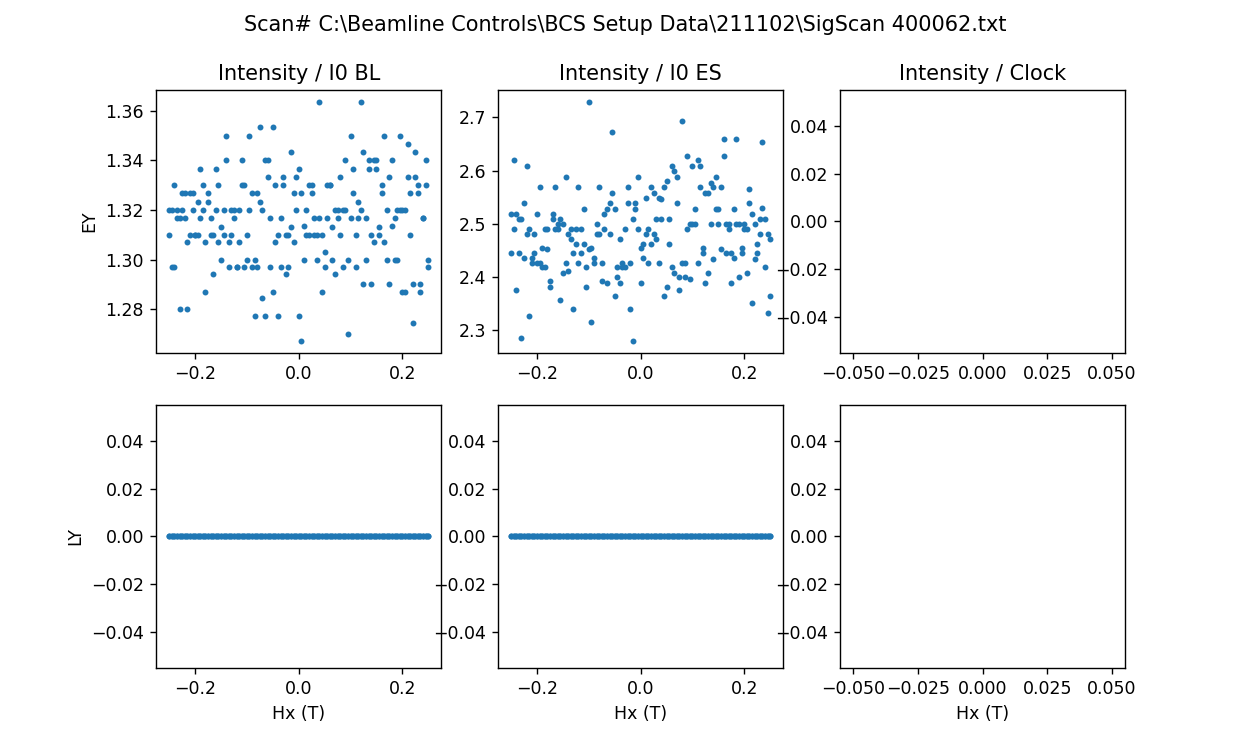

Text(0.5, 0, 'Hx (T)')

Text(0.5, 0, 'Hx (T)')

Text(0.5, 0, 'Hx (T)')

Text(0, 0.5, 'EY')

Text(0, 0.5, 'LY')

Text(0.5, 1.0, 'Intensity / I0 BL')

Text(0.5, 1.0, 'Intensity / I0 ES')

Text(0.5, 1.0, 'Intensity / Clock')

Text(0.5, 0.98, 'Scan# C:\\Beamline Controls\\BCS Setup Data\\211102\\SigScan 400062.txt')

INFO:bluesky:Executing plan <generator object fly at 0x000001B12159ACF0>
INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x000001B1084B1EB0> from 'idle' -> 'running'




Transient Scan ID: 3     Time: 2021-11-02 17:57:24
Persistent Unique Scan ID: '6cd25210-459b-4243-9405-f952bbede052'


INFO:root:complete() starting


ssflyFlyMagField_done [In progress. No progress bar available.]                                                        
Scan is finshed!


INFO:root:complete() ending


ssflyFlyMagField_done [In progress. No progress bar available.]                                                        
                                                                                                                       
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |         Hx |
+-----------+------------+------------+
+-----------+------------+------------+
generator fly ['6cd25210'] (scan num: 3)





INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x000001B1084B1EB0> from 'running' -> 'idle'
INFO:bluesky:Cleaned up from plan <generator object fly at 0x000001B12159ACF0>


('6cd25210-459b-4243-9405-f952bbede052',)

False

True

data_file='C:\\Beamline Controls\\BCS Setup Data\\211102\\SigScan 400063.txt'


<IPython.core.display.Javascript object>


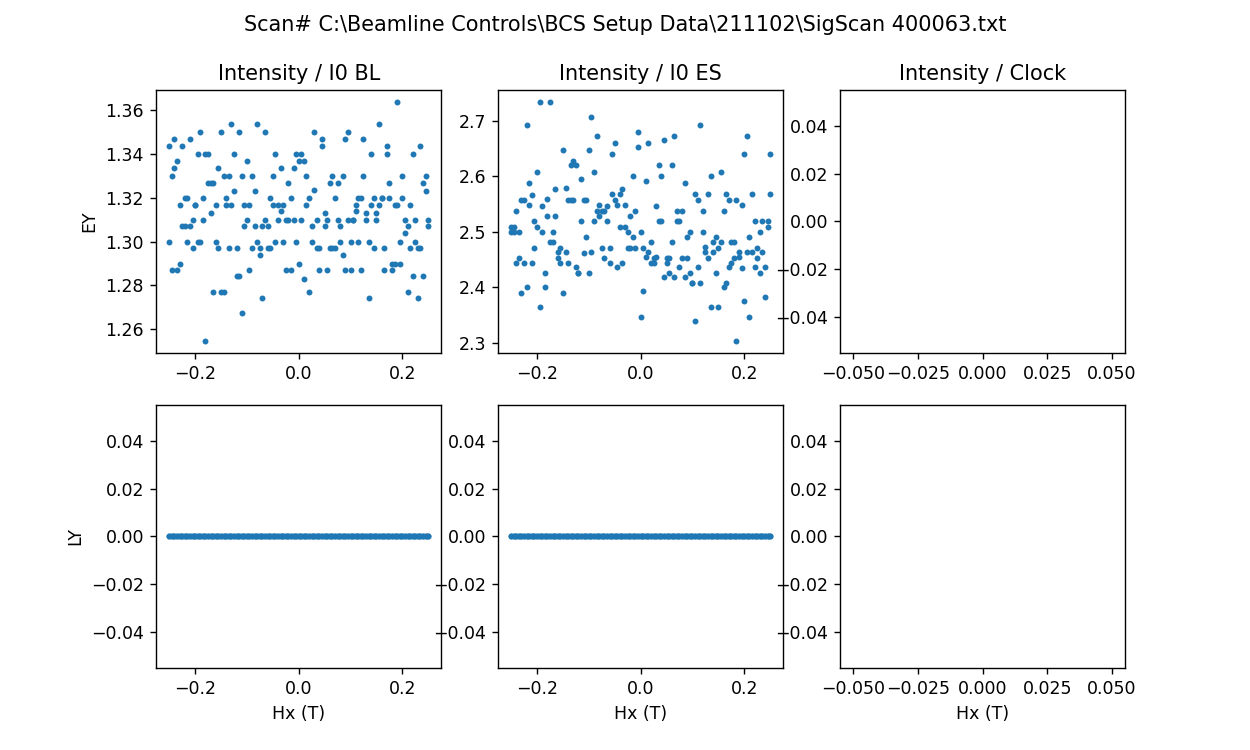

Text(0.5, 0, 'Hx (T)')

Text(0.5, 0, 'Hx (T)')

Text(0.5, 0, 'Hx (T)')

Text(0, 0.5, 'EY')

Text(0, 0.5, 'LY')

Text(0.5, 1.0, 'Intensity / I0 BL')

Text(0.5, 1.0, 'Intensity / I0 ES')

Text(0.5, 1.0, 'Intensity / Clock')

Text(0.5, 0.98, 'Scan# C:\\Beamline Controls\\BCS Setup Data\\211102\\SigScan 400063.txt')

INFO:bluesky:Executing plan <generator object fly at 0x000001B121E5B040>
INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x000001B1084B1EB0> from 'idle' -> 'running'




Transient Scan ID: 4     Time: 2021-11-02 17:58:33
Persistent Unique Scan ID: 'b47e2b23-9737-4f74-b886-b7c0119d56b2'


INFO:root:complete() starting


ssflyFlyMagField_done [In progress. No progress bar available.]                                                        
Scan is finshed!


INFO:root:complete() ending


ssflyFlyMagField_done [In progress. No progress bar available.]                                                        
                                                                                                                       
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |         Hx |
+-----------+------------+------------+
+-----------+------------+------------+
generator fly ['b47e2b23'] (scan num: 4)





INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x000001B1084B1EB0> from 'running' -> 'idle'
INFO:bluesky:Cleaned up from plan <generator object fly at 0x000001B121E5B040>


('b47e2b23-9737-4f74-b886-b7c0119d56b2',)

False

True

data_file='C:\\Beamline Controls\\BCS Setup Data\\211102\\SigScan 400064.txt'


<IPython.core.display.Javascript object>


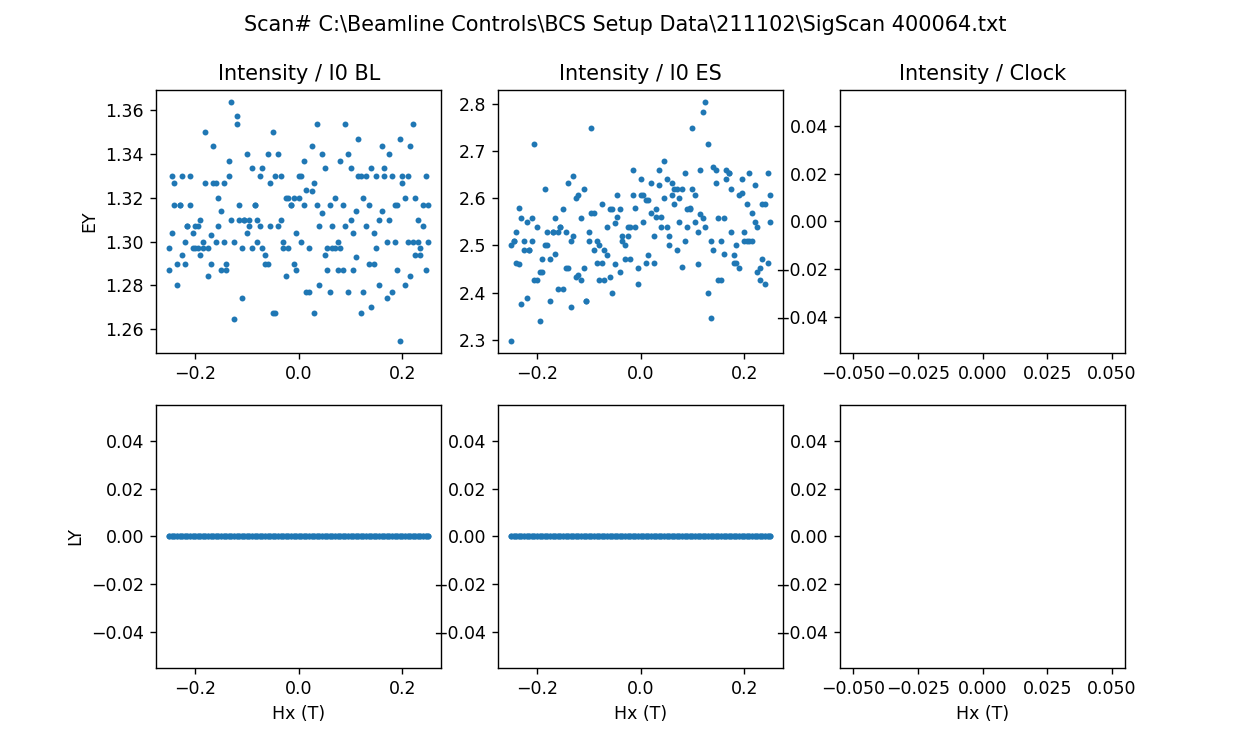

Text(0.5, 0, 'Hx (T)')

Text(0.5, 0, 'Hx (T)')

Text(0.5, 0, 'Hx (T)')

Text(0, 0.5, 'EY')

Text(0, 0.5, 'LY')

Text(0.5, 1.0, 'Intensity / I0 BL')

Text(0.5, 1.0, 'Intensity / I0 ES')

Text(0.5, 1.0, 'Intensity / Clock')

Text(0.5, 0.98, 'Scan# C:\\Beamline Controls\\BCS Setup Data\\211102\\SigScan 400064.txt')

INFO:bluesky:Executing plan <generator object fly at 0x000001B122685200>
INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x000001B1084B1EB0> from 'idle' -> 'running'




Transient Scan ID: 5     Time: 2021-11-02 17:59:41
Persistent Unique Scan ID: '64257679-2b88-459d-bd10-b6a38263f17b'


INFO:root:complete() starting


ssflyFlyMagField_done [In progress. No progress bar available.]                                                        
Scan is finshed!


INFO:root:complete() ending


ssflyFlyMagField_done [In progress. No progress bar available.]                                                        
                                                                                                                       
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |         Hx |
+-----------+------------+------------+
+-----------+------------+------------+
generator fly ['64257679'] (scan num: 5)





INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x000001B1084B1EB0> from 'running' -> 'idle'
INFO:bluesky:Cleaned up from plan <generator object fly at 0x000001B122685200>


('64257679-2b88-459d-bd10-b6a38263f17b',)

False

True

data_file='C:\\Beamline Controls\\BCS Setup Data\\211102\\SigScan 400065.txt'


<IPython.core.display.Javascript object>


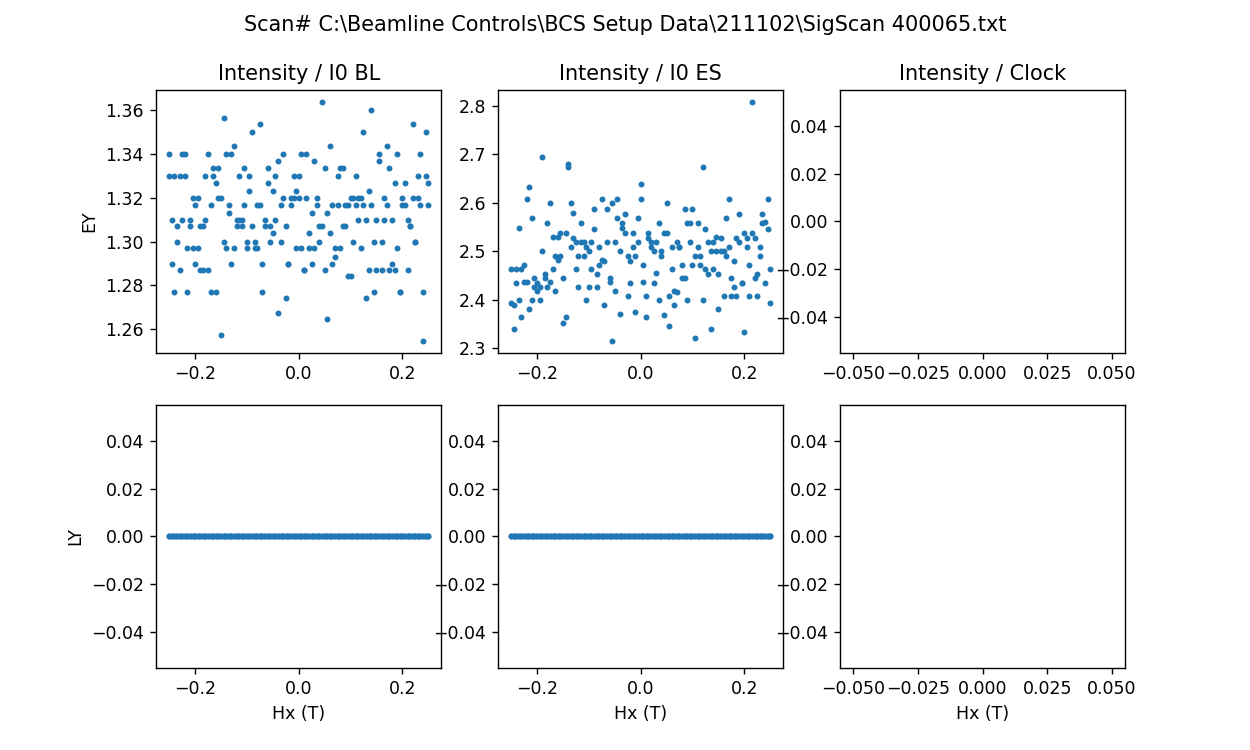

Text(0.5, 0, 'Hx (T)')

Text(0.5, 0, 'Hx (T)')

Text(0.5, 0, 'Hx (T)')

Text(0, 0.5, 'EY')

Text(0, 0.5, 'LY')

Text(0.5, 1.0, 'Intensity / I0 BL')

Text(0.5, 1.0, 'Intensity / I0 ES')

Text(0.5, 1.0, 'Intensity / Clock')

Text(0.5, 0.98, 'Scan# C:\\Beamline Controls\\BCS Setup Data\\211102\\SigScan 400065.txt')

data_files=['C:\\Beamline Controls\\BCS Setup Data\\211102\\SigScan 400062.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211102\\SigScan 400063.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211102\\SigScan 400064.txt', 'C:\\Beamline Controls\\BCS Setup Data\\211102\\SigScan 400065.txt']


In [31]:
data_files = list()
normalization_signals = ["I0 BL", "I0 ES", "Clock"]
intensity_signals = ["EY", "LY"]
primary_motor = "Hx"
sample_name = "None"
element = "None"

for repeat in range(4):
    RE(fly(
        [fly_FlyMagField], 
        md=dict(
            purpose="demo bluesky fly plan with BCS Single Motor Flying Scan",
            sample_name=sample_name,
            element=element, 
            loop=repeat + 1, 
            scan_type="flying",
            project="DD-00598-001: Magnetic Interactions in High Entropy Magnetic Systems",
            beamline="4.0.2",
            endstation="VMM",
            tracking="ALS-DXR-0066",
            normalization_signals=normalization_signals,
            intensity_signals=intensity_signals,
            hints={
                "dimensions": [([primary_motor], "primary")],
                "fields": intensity_signals,
            },
            ),
        ))

    fly_FlyMagField.busy.get()
    fly_FlyMagField.done.get()
    data_file = fly_FlyMagField.data_path.get()
    print(f"{data_file=}")

    data_files.append(data_file)

    run = db.v2[-1]
    data = run.primary.read()

    fig, axes = plt.subplots(nrows=len(intensity_signals), ncols=len(normalization_signals), figsize=(10,6))
    axes_iter = iter(axes.flatten())
    for intensity_signal in intensity_signals:
        for normalization_signal in normalization_signals:

            ax=next(axes_iter)
            ax.scatter(
                x=data[primary_motor], 
                y=data[intensity_signal] / data[normalization_signal], 
                linestyles='-', 
                linewidths=2,
                s=2,
                )
    for ax in axes[-1]:
        ax.set_xlabel(f"{primary_motor} (T)") # Assume magnetic field units
    for (ax, signal) in zip(axes[:, 0], intensity_signals):
        ax.set_ylabel(f"{signal}")
    for (ax, norm_signal) in zip(axes[0], normalization_signals):
        ax.set_title(f"Intensity / {norm_signal}")
    fig.suptitle(f'Scan# {data_file}')
    plt.show()
    
print(f"{data_files=}")

### Trajectory Scan

In [32]:
fly_FlyLoops = BcsTrajScanFlyer("BCS402_VMM:", name="ssflyFlyLoops")

In [33]:
fly_FlyLoops.scan_setup(
        bcs_server=bl402vmm, 
        input_file_path=os.path.join(
            str(os.environ["VMM_REMOTE_SCAN_PATH"]),
            "Padraic\\2021-10-26\\0.25T_loop_d0.005T_noEPU_x10.txt",
            ), 
        subpath_replace_dict=collections.OrderedDict([
            (str(os.environ["VMM_REMOTE_SCAN_PATH"]), str(os.environ["VMM_LOCAL_SCAN_PATH"])),
            ]),
        shift_flying_data=True,
    )

In [34]:
fly_FlyLoops.get()

BcsTrajScanFlyerTuple(input_file_path='C:\\\\experiments\\\\Padraic\\2021-10-26\\0.25T_loop_d0.005T_noEPU_x10.txt', delay_sec=0.0, count_sec=1.0, num_scans=1, skip_unchanged_motors=True, move_sequentially=False, shift_flying_data=True, final_move='Stay', final_trajectory_name='', memo='', filename_pattern='*.txt', ready=True, busy=False, done=True, execute_scan=True, data_paths='', normal_motors=[], flying_motor='Hx', stream_event_sizes=[103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103], yield_array_events=True)

In [35]:
data_files = list()
normalization_signals = ["I0 BL", "I0 ES", "Clock"]
intensity_signals = ["EY", "LY"]
primary_motor = "Hx Actual"
sample_name = "None"
element = "None"

RE(fly(
    [fly_FlyLoops], 
    md=dict(
        purpose="example XMCD loops vs. sample",
        sample_name=sample_name,
        element=element, 
        scan_type="flying",
        project="DD-00598-001: Magnetic Interactions in High Entropy Magnetic Systems",
        beamline="4.0.2",
        endstation="VMM",
        tracking="ALS-DXR-0066",
        normalization_signals=normalization_signals,
        intensity_signals=intensity_signals,
        hints={
            "dimensions": [([primary_motor], "primary")],
            "fields": intensity_signals,
        },
    ),
))

fly_FlyLoops.busy.get()
fly_FlyLoops.done.get()
data_file = fly_FlyLoops.data_paths.get()
print(f"{data_file=}")

data_files.append(data_file)

run = db.v2[-1]
data = run.primary.read()

fig, axes = plt.subplots(nrows=len(intensity_signals), ncols=len(normalization_signals), figsize=(10,6))
axes_iter = iter(axes.flatten())
for intensity_signal in intensity_signals:
    for normalization_signal in normalization_signals:

        ax=next(axes_iter)
        ax.scatter(
            x=data[primary_motor], 
            y=data[intensity_signal] / data[normalization_signal], 
            linestyles='-', 
            linewidths=2,
            s=2,
            )
for ax in axes[-1]:
    ax.set_xlabel(f"{primary_motor} (eV)") # Assume energy units
for (ax, signal) in zip(axes[:, 0], intensity_signals):
    ax.set_ylabel(f"{signal}")
for (ax, norm_signal) in zip(axes[0], normalization_signals):
    ax.set_title(f"Intensity / {norm_signal}")
fig.suptitle(f'Scan# {data_file}')
plt.show()

print(f"{data_files=}")

INFO:bluesky:Executing plan <generator object fly at 0x000001B1215C7E40>
INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x000001B1084B1EB0> from 'idle' -> 'running'




Transient Scan ID: 6     Time: 2021-11-02 18:09:52
Persistent Unique Scan ID: 'a635afcb-d19a-4b09-b467-7cb2c0a988c2'


INFO:root:complete() starting


Adding new data file
ssflyFlyLoops_done [In progress. No progress bar available.]                                                           
Scan is finshed!


INFO:root:complete() ending


ssflyFlyLoops_done [In progress. No progress bar available.]                                                           
                                                                                                                       
scan_channels = ['Time of Day', 'Time (s)', 'Hx Actual', 'I0 BL', 'I0 ES', 'EY', 'LY', 'FY', 'Clock', 'PD', 'EY SCVM', 'LY SCVM', 'Temp A', 'Temp B', 'Cryogen Totalizer', 'X', 'Y', 'Z', 'Theta', 'Beam Current', 'Cryo Heater Power', 'Temp A (HT)', 'Temp B (HT)', 'Hx', 'Hy', 'Hz', 'XMCD H', 'XMCD Phi', 'XMLD H', 'XMLD Phi', 'XMLD Theta', 'Entrance Slit Width', 'Exit Slit Width', 'M206 Pitch', 'M201 Roll', 'I0 ES Amp (nA)', 'I0 BL Amp (nA)', 'EY Amp (nA)', 'LY Amp (nA)', 'FY Amp (nA)', 'Energy', 'Polarization', 'Premirror', 'MonoGrating', 'EPU Gap', 'EPU Z', 'Power Sensor', "Counter 4 Don't use", "Counter 5 Don't use", 'Keithley 6487 Voltage', 'Keithley 6487 Meas Curr Range', 'Voltage 0', 'Voltage 1', 'Voltage 2', 'Voltage 3', 'Hall 1', 'Hall 2', 'Hall 

C:\experiments\beamline_commissioning\BCS-API\bcs_events.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df[output_col] = datetimes
C:\Users\admin\miniconda3\envs\bluesky\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
ERROR:bluesky:Run aborted
Traceback (most recent call last):
  File "C:\Users\admin\miniconda3\envs\bluesky\lib\site-packages\bluesky\run_engine.py", line 1479, in _run
    msg = self._plan_stack[-1].throw(
  File "C:\Users\admin\miniconda3\envs\bluesky\lib\site-packages\b

+-----------+------------+------------+
generator fly ['a635afcb'] (scan num: 6)





INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x000001B1084B1EB0> from 'running' -> 'idle'


IndexError: single positional indexer is out-of-bounds

^^^---   Trajectory Scan stops after one line (one flying command)!

In [37]:
fly_FlyLoops.scan_setup(
        bcs_server=bl402vmm, 
        input_file_path=os.path.join(
            str(os.environ["VMM_REMOTE_SCAN_PATH"]),
            "Padraic\\2021-10-26\\0.25T_loop_d0.005T_noEPU_v6_x10.txt",
            ), 
        subpath_replace_dict=collections.OrderedDict([
            (str(os.environ["VMM_REMOTE_SCAN_PATH"]), str(os.environ["VMM_LOCAL_SCAN_PATH"])),
            ]),
        shift_flying_data=True,
    )

In [38]:
fly_FlyLoops.get()

BcsTrajScanFlyerTuple(input_file_path='C:\\\\experiments\\\\Padraic\\2021-10-26\\0.25T_loop_d0.005T_noEPU_v6_x10.txt', delay_sec=0.0, count_sec=1.0, num_scans=1, skip_unchanged_motors=True, move_sequentially=False, shift_flying_data=True, final_move='Stay', final_trajectory_name='', memo='', filename_pattern='*.txt', ready=True, busy=False, done=True, execute_scan=False, data_paths=['C:\\Beamline Controls\\BCS Setup Data\\211102\\TrajScan 400068.txt'], normal_motors=['EPU Harmonic'], flying_motor='Hx', stream_event_sizes=[103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103], yield_array_events=True)

INFO:bluesky:Executing plan <generator object fly at 0x000001B12191C900>
INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x000001B1084B1EB0> from 'idle' -> 'running'




Transient Scan ID: 7     Time: 2021-11-02 18:13:24
Persistent Unique Scan ID: '86ca562a-df17-4cce-a423-447c9d013bee'


INFO:root:complete() starting


Adding new data file
ssflyFlyLoops_done [In progress. No progress bar available.]                                                           
Scan is finshed!


INFO:root:complete() ending


ssflyFlyLoops_done [In progress. No progress bar available.]                                                           
                                                                                                                       
scan_channels = ['Time of Day', 'Time (s)', 'EPU Harmonic Goal', 'EPU Harmonic Actual', 'Hx Actual', 'I0 BL', 'I0 ES', 'EY', 'LY', 'FY', 'Clock', 'PD', 'EY SCVM', 'LY SCVM', 'Temp A', 'Temp B', 'Cryogen Totalizer', 'X', 'Y', 'Z', 'Theta', 'Beam Current', 'Cryo Heater Power', 'Temp A (HT)', 'Temp B (HT)', 'Hx', 'Hy', 'Hz', 'XMCD H', 'XMCD Phi', 'XMLD H', 'XMLD Phi', 'XMLD Theta', 'Entrance Slit Width', 'Exit Slit Width', 'M206 Pitch', 'M201 Roll', 'I0 ES Amp (nA)', 'I0 BL Amp (nA)', 'EY Amp (nA)', 'LY Amp (nA)', 'FY Amp (nA)', 'Energy', 'Polarization', 'Premirror', 'MonoGrating', 'EPU Gap', 'EPU Z', 'Power Sensor', "Counter 4 Don't use", "Counter 5 Don't use", 'Keithley 6487 Voltage', 'Keithley 6487 Meas Curr Range', 'Voltage 0', 'Voltage 1', 'Voltage

INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x000001B1084B1EB0> from 'running' -> 'idle'
INFO:bluesky:Cleaned up from plan <generator object fly at 0x000001B12191C900>


('86ca562a-df17-4cce-a423-447c9d013bee',)

False

True

data_file=['C:\\Beamline Controls\\BCS Setup Data\\211102\\TrajScan 400069.txt']


<IPython.core.display.Javascript object>


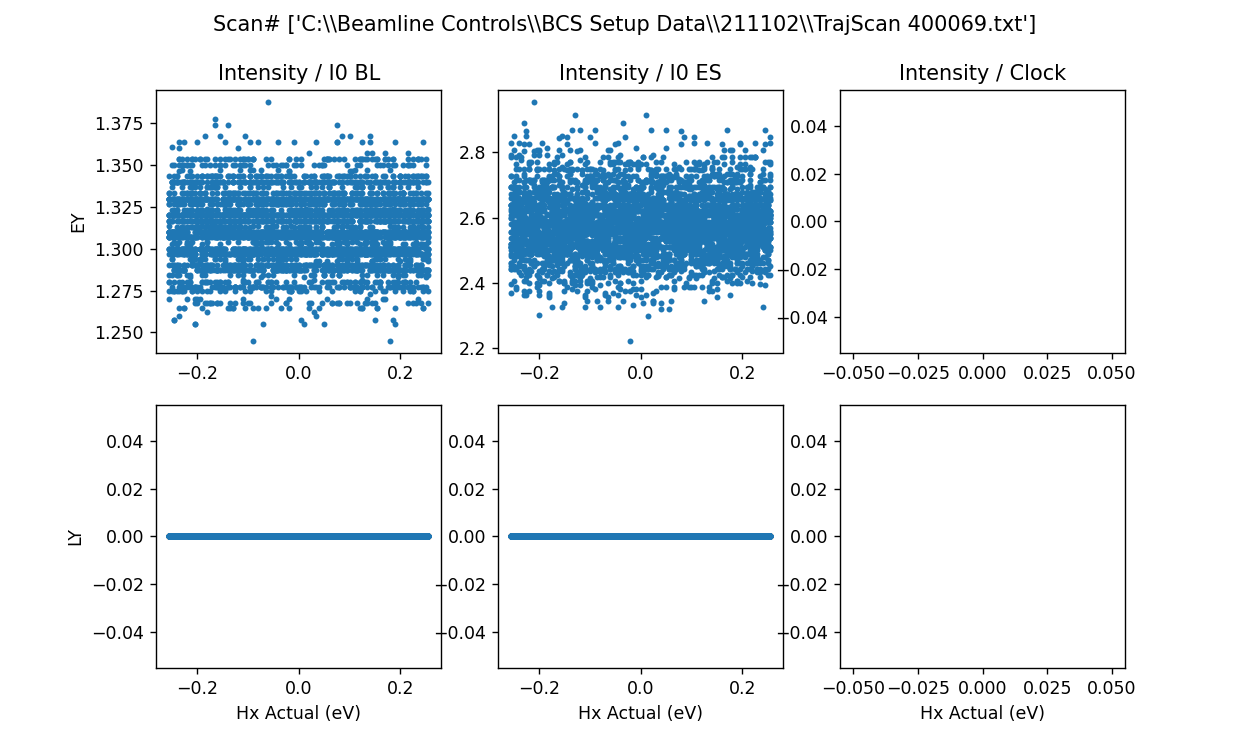

Text(0.5, 0, 'Hx Actual (eV)')

Text(0.5, 0, 'Hx Actual (eV)')

Text(0.5, 0, 'Hx Actual (eV)')

Text(0, 0.5, 'EY')

Text(0, 0.5, 'LY')

Text(0.5, 1.0, 'Intensity / I0 BL')

Text(0.5, 1.0, 'Intensity / I0 ES')

Text(0.5, 1.0, 'Intensity / Clock')

Text(0.5, 0.98, "Scan# ['C:\\\\Beamline Controls\\\\BCS Setup Data\\\\211102\\\\TrajScan 400069.txt']")

data_files=[['C:\\Beamline Controls\\BCS Setup Data\\211102\\TrajScan 400069.txt']]


In [39]:
data_files = list()
normalization_signals = ["I0 BL", "I0 ES", "Clock"]
intensity_signals = ["EY", "LY"]
primary_motor = "Hx Actual"
sample_name = "None"
element = "None"

RE(fly(
    [fly_FlyLoops], 
    md=dict(
        purpose="example XMCD loops vs. sample",
        sample_name=sample_name,
        element=element, 
        scan_type="flying",
        project="DD-00598-001: Magnetic Interactions in High Entropy Magnetic Systems",
        beamline="4.0.2",
        endstation="VMM",
        tracking="ALS-DXR-0066",
        normalization_signals=normalization_signals,
        intensity_signals=intensity_signals,
        hints={
            "dimensions": [([primary_motor], "primary")],
            "fields": intensity_signals,
        },
    ),
))

fly_FlyLoops.busy.get()
fly_FlyLoops.done.get()
data_file = fly_FlyLoops.data_paths.get()
print(f"{data_file=}")

data_files.append(data_file)

run = db.v2[-1]
data = run.primary.read()

fig, axes = plt.subplots(nrows=len(intensity_signals), ncols=len(normalization_signals), figsize=(10,6))
axes_iter = iter(axes.flatten())
for intensity_signal in intensity_signals:
    for normalization_signal in normalization_signals:

        ax=next(axes_iter)
        ax.scatter(
            x=data[primary_motor], 
            y=data[intensity_signal] / data[normalization_signal], 
            linestyles='-', 
            linewidths=2,
            s=2,
            )
for ax in axes[-1]:
    ax.set_xlabel(f"{primary_motor} (eV)") # Assume energy units
for (ax, signal) in zip(axes[:, 0], intensity_signals):
    ax.set_ylabel(f"{signal}")
for (ax, norm_signal) in zip(axes[0], normalization_signals):
    ax.set_title(f"Intensity / {norm_signal}")
fig.suptitle(f'Scan# {data_file}')
plt.show()

print(f"{data_files=}")